1. Intro
1.1 Utilidade: criadores e kennels
2. Os dados
2.1 Obter de http://vision.stanford.edu/aditya86/ImageNetDogs/
2.2 Colocar no diretório "data"
3. O trabalho sobre os dados
4. Transfer Learning
5. VGG

In [ ]:
import tarfile
import urllib.request
import os
import os.path
import shutil
import numpy as np
import traceback


import matplotlib.pyplot as plt

from six.moves import cPickle as pickle
from xml.dom import minidom
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import layers
from keras import models
from keras import optimizers
from scipy import io,misc
from keras.applications.vgg16 import VGG16
from PIL import Image
from matplotlib.pyplot import imshow

import numpy as np
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model

In [2]:
base_dir = "workdir"
image_size = 224
np.random.seed(42)
num_channels=3 #rgb

In [23]:
if (not os.path.exists(base_dir)):
        os.mkdir(base_dir)

def untar_if_not_exists(src, dest, create_dest=False):
    final_path=os.path.join(base_dir, dest)
    if (not os.path.exists(final_path)):
        tar_file = src
        untar_dest=base_dir
        if (create_dest):
            os.mkdir(os.path.join(base_dir, dest))
            untar_dest=os.path.join(base_dir, dest)
        tar = tarfile.open(tar_file)
        tar.extractall(untar_dest)
        tar.close()
        
def count_files(folder):
    count = 0
    base_path=os.path.join(base_dir, folder)
    for file in os.listdir(base_path):
        path=base_path+file
        if (os.path.isdir(path)):
            count += count_files(path)
        else:
            count += 1
    return count

def file_create(path):
    if (not os.path.exists(path)):
        os.mkdir(path)
        
def split_classes(path, qtd_classes):
    data_folders = [os.path.join(path, d) for d in sorted(os.listdir(path)) if os.path.isdir(os.path.join(path, d))]
    if len(data_folders) != qtd_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (qtd_classes, len(data_folders)))
    return data_folders

def move_data_files(image_list, new_folder):
    for file in image_list:
        if os.path.exists('workdir/Images/'+file[0][0]):
            shutil.move('workdir/Images/'+file[0][0],new_folder+'/'+file[0][0])
        elif not os.path.exists(base_dir+"/"+new_folder+'/'+file[0][0]):
           print('%s does not exist, it may be missing' % os.path.exists('./images/'+file[0][0]))
    return [new_folder+'/'+d for d in sorted(os.listdir(new_folder)) if os.path.isdir(os.path.join(new_folder, d))]

def convert_image(image_file):
    im = Image.open(image_file)
    rgb_im = im.convert('RGB')
    rgb_im.save(image_file)
    
def convert_all_images():
    images_folder = os.path.join(base_dir, "Images")
    for folder in os.listdir(images_folder):
        current_folder = os.path.join(images_folder, folder)
        print(f'folder {current_folder}')
        if (os.path.isdir(current_folder)):
            for image_file in os.listdir(current_folder):
                image_file_path=os.path.join(current_folder, image_file)
                convert_image(image_file_path)
                print(f'converted {image_file_path}')
                
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [4]:
untar_if_not_exists("data/annotation.tar", "Annotation")
untar_if_not_exists("data/images.tar", "Images")
untar_if_not_exists("data/lists.tar", "Lists", True)

qtd_classes = count_files("Annotation")

print("Annotations: " + str(qtd_classes))
print("Images: " + str(count_files("Images")))
print("List: " + str(count_files("Lists")))

Annotations: 120
Images: 120
List: 3


In [ ]:
#resolve o problema 'cannot write mode RGBA as JPEG' em um arquivo do dataset
convert_all_images()

In [6]:
file_create("workdir/train")
file_create("workdir/racastest")
file_create("workdir/cropped")
file_create("workdir/cropped/train")
file_create("workdir/cropped/test")

annotations_folders=split_classes(os.path.join(base_dir, "Annotation"), qtd_classes)
images_folders=split_classes(os.path.join(base_dir, "Images"), qtd_classes)

for folder in images_folders:
    os.makedirs("workdir/train/"+folder.split("\\")[-1])
    os.makedirs("workdir/test/"+folder.split("\\")[-1])
    os.makedirs("workdir/cropped/train/"+folder.split("\\")[-1])
    os.makedirs("workdir/cropped/test/"+folder.split("\\")[-1])

In [5]:
test_list = io.loadmat('workdir/Lists/test_list.mat')['file_list']
train_list = io.loadmat('workdir/Lists/train_list.mat')['file_list']

print(f'Test files: {test_list}')
print(f'Train files: {train_list}')

Test files: [[array(['n02085620-Chihuahua/n02085620_2650.jpg'], dtype='<U38')]
 [array(['n02085620-Chihuahua/n02085620_4919.jpg'], dtype='<U38')]
 [array(['n02085620-Chihuahua/n02085620_1765.jpg'], dtype='<U38')]
 ...
 [array(['n02116738-African_hunting_dog/n02116738_3635.jpg'], dtype='<U48')]
 [array(['n02116738-African_hunting_dog/n02116738_2988.jpg'], dtype='<U48')]
 [array(['n02116738-African_hunting_dog/n02116738_6330.jpg'], dtype='<U48')]]
Train files: [[array(['n02085620-Chihuahua/n02085620_5927.jpg'], dtype='<U38')]
 [array(['n02085620-Chihuahua/n02085620_4441.jpg'], dtype='<U38')]
 [array(['n02085620-Chihuahua/n02085620_1502.jpg'], dtype='<U38')]
 ...
 [array(['n02116738-African_hunting_dog/n02116738_6754.jpg'], dtype='<U48')]
 [array(['n02116738-African_hunting_dog/n02116738_9333.jpg'], dtype='<U48')]
 [array(['n02116738-African_hunting_dog/n02116738_2503.jpg'], dtype='<U48')]]


In [7]:
test_folders = move_data_files(test_list, 'workdir/test')
train_folders = move_data_files(train_list, 'workdir/train')

False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing
False does not exist, it may be missing


In [8]:
def load_breed(folder):
    """
    Load the data for a single breed label.
    """
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size,num_channels), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = folder+'/'+image
        try:
            
            image_data = misc.imread(image_file)
            
            annon_file = 'workdir/Annotation' + '/' + folder.split('/')[-1] + '/' + image.split('.')[0]
            annon_xml = minidom.parse(annon_file)
            xmin = int(annon_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
            ymin = int(annon_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
            xmax = int(annon_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
            ymax = int(annon_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)
            
            new_image_data = image_data[ymin:ymax,xmin:xmax,:]
            new_image_data = misc.imresize(new_image_data, (image_size, image_size))
            misc.imsave('workdir/cropped/' + folder.split('workdir/')[1] + '/' + image, new_image_data)
            dataset[num_images, :, :, :] = new_image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :, :]

    print('Full dataset tensor:', dataset.shape)
    return dataset

In [9]:
dataset = load_breed('workdir/train/n02105855-Shetland_sheepdog')
with open('n02105855-Shetland_sheepdog.pickle', 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)

workdir/train/n02105855-Shetland_sheepdog


C:\Users\leand\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
C:\Users\leand\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
C:\Users\leand\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Full dataset tensor: (100, 224, 224, 3)


In [10]:
def maybe_pickle(data_folders, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_breed(folder)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

In [11]:
train_datasets = maybe_pickle(train_folders, force=True)
test_datasets = maybe_pickle(test_folders, force=True)

Pickling workdir/train/n02085620-Chihuahua.pickle.
workdir/train/n02085620-Chihuahua


C:\Users\leand\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
C:\Users\leand\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
C:\Users\leand\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02085782-Japanese_spaniel.pickle.
workdir/train/n02085782-Japanese_spaniel
Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02085936-Maltese_dog.pickle.
workdir/train/n02085936-Maltese_dog
Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02086079-Pekinese.pickle.
workdir/train/n02086079-Pekinese
Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02086240-Shih-Tzu.pickle.
workdir/train/n02086240-Shih-Tzu
Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02086646-Blenheim_spaniel.pickle.
workdir/train/n02086646-Blenheim_spaniel
Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02086910-papillon.pickle.
workdir/train/n02086910-papillon
Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02087046-toy_terrier.pickle.
workdir/train/n02087046-toy_terrier
Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02087394-Rhodesian_ridgeback.pi

Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02100877-Irish_setter.pickle.
workdir/train/n02100877-Irish_setter
Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02101006-Gordon_setter.pickle.
workdir/train/n02101006-Gordon_setter
Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02101388-Brittany_spaniel.pickle.
workdir/train/n02101388-Brittany_spaniel
Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02101556-clumber.pickle.
workdir/train/n02101556-clumber
Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02102040-English_springer.pickle.
workdir/train/n02102040-English_springer
Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02102177-Welsh_springer_spaniel.pickle.
workdir/train/n02102177-Welsh_springer_spaniel
Full dataset tensor: (100, 224, 224, 3)
Pickling workdir/train/n02102318-cocker_spaniel.pickle.
workdir/train/n02102318-cocker_spaniel
Full dataset tensor: (100, 224, 224, 3)
Pickling wo

Full dataset tensor: (114, 224, 224, 3)
Pickling workdir/test/n02086646-Blenheim_spaniel.pickle.
workdir/test/n02086646-Blenheim_spaniel
Full dataset tensor: (88, 224, 224, 3)
Pickling workdir/test/n02086910-papillon.pickle.
workdir/test/n02086910-papillon
Full dataset tensor: (96, 224, 224, 3)
Pickling workdir/test/n02087046-toy_terrier.pickle.
workdir/test/n02087046-toy_terrier
Full dataset tensor: (72, 224, 224, 3)
Pickling workdir/test/n02087394-Rhodesian_ridgeback.pickle.
workdir/test/n02087394-Rhodesian_ridgeback
Full dataset tensor: (72, 224, 224, 3)
Pickling workdir/test/n02088094-Afghan_hound.pickle.
workdir/test/n02088094-Afghan_hound
Full dataset tensor: (139, 224, 224, 3)
Pickling workdir/test/n02088238-basset.pickle.
workdir/test/n02088238-basset
Full dataset tensor: (75, 224, 224, 3)
Pickling workdir/test/n02088364-beagle.pickle.
workdir/test/n02088364-beagle
Full dataset tensor: (95, 224, 224, 3)
Pickling workdir/test/n02088466-bloodhound.pickle.
workdir/test/n02088466-b

Full dataset tensor: (59, 224, 224, 3)
Pickling workdir/test/n02102177-Welsh_springer_spaniel.pickle.
workdir/test/n02102177-Welsh_springer_spaniel
Full dataset tensor: (50, 224, 224, 3)
Pickling workdir/test/n02102318-cocker_spaniel.pickle.
workdir/test/n02102318-cocker_spaniel
Full dataset tensor: (59, 224, 224, 3)
Pickling workdir/test/n02102480-Sussex_spaniel.pickle.
workdir/test/n02102480-Sussex_spaniel
Full dataset tensor: (51, 224, 224, 3)
Pickling workdir/test/n02102973-Irish_water_spaniel.pickle.
workdir/test/n02102973-Irish_water_spaniel
Full dataset tensor: (50, 224, 224, 3)
Pickling workdir/test/n02104029-kuvasz.pickle.
workdir/test/n02104029-kuvasz
Full dataset tensor: (50, 224, 224, 3)
Pickling workdir/test/n02104365-schipperke.pickle.
workdir/test/n02104365-schipperke
Full dataset tensor: (54, 224, 224, 3)
Pickling workdir/test/n02105056-groenendael.pickle.
workdir/test/n02105056-groenendael
Full dataset tensor: (50, 224, 224, 3)
Pickling workdir/test/n02105162-malinois.

In [12]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows,img_size, img_size,num_channels), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

In [13]:
def merge_datasets(pickle_files, train_size, valid_size=0, even_size=True):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                breed_set = pickle.load(f)
                np.random.shuffle(breed_set)
                
            if not even_size:
                tsize_per_class,end_l = len(breed_set),len(breed_set)
                end_t = start_t + tsize_per_class
                
            if valid_dataset is not None:
                valid_breed = breed_set[:vsize_per_class, :, :, :]
                valid_dataset[start_v:end_v, :, :, :] = valid_breed
                valid_labels[start_v:end_v] = label
                start_v += vsize_per_class
                end_v += vsize_per_class

            
            train_breed = breed_set[vsize_per_class:end_l, :, :, :]
            train_dataset[start_t:end_t, :, :, :] = train_breed
            train_labels[start_t:end_t] = label
            start_t += tsize_per_class
            end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels

In [14]:
train_size = 9600
valid_size = 2400
test_size = 8580

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size, even_size=False)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (9600, 224, 224, 3) (9600,)
Validation: (2400, 224, 224, 3) (2400,)
Testing: (8580, 224, 224, 3) (8580,)


In [15]:
i=image.load_img('workdir/cropped/test/n02085620-Chihuahua/n02085620_588.jpg',target_size=(229,229))
image.img_to_array(i).shape

(229, 229, 3)

C:\Users\leand\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


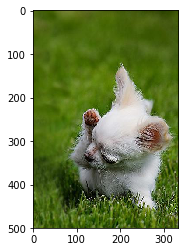

In [16]:
imshow(misc.imread('workdir/test/n02085620-Chihuahua/n02085620_588.jpg')[:,:,:3])

In [17]:
batch_size=16

train_datagen = ImageDataGenerator(rotation_range=15, shear_range=0.1, channel_shift_range=20,
                                    width_shift_range=0.1,  height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory('workdir/cropped/train', target_size=(224,224),
            class_mode='categorical', shuffle=True, batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory('workdir/cropped/test', target_size=(224,224),
            class_mode='categorical', shuffle=False, batch_size=batch_size)

Found 12000 images belonging to 120 classes.
Found 8580 images belonging to 120 classes.


In [18]:
base_model = VGG16(include_top=False,
                  input_shape = (224,224,3),
                  weights = 'imagenet')
x = base_model.output
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

predictions = Dense(120, activation='softmax')(x)


model = Model(input=base_model.input, output=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\leand\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [22]:
history = model.fit_generator(train_generator,
                              validation_data=validation_generator, 
                              validation_steps=100, 
                              steps_per_epoch  = 100,
                              epochs = 10)

Epoch 1/10
100/100 [==============================] - 997s 10s/step - loss: 5.0213 - acc: 0.0338 - val_loss: 3.7545 - val_acc: 0.1519
Epoch 2/10
100/100 [==============================] - 962s 10s/step - loss: 4.4319 - acc: 0.0925 - val_loss: 2.9375 - val_acc: 0.3006
Epoch 3/10
100/100 [==============================] - 929s 9s/step - loss: 4.0551 - acc: 0.1194 - val_loss: 3.1162 - val_acc: 0.2156
Epoch 4/10
100/100 [==============================] - 936s 9s/step - loss: 3.6601 - acc: 0.1531 - val_loss: 2.5302 - val_acc: 0.3350
Epoch 5/10
100/100 [==============================] - 928s 9s/step - loss: 3.4324 - acc: 0.2000 - val_loss: 2.0751 - val_acc: 0.4469
Epoch 6/10
100/100 [==============================] - 920s 9s/step - loss: 3.2136 - acc: 0.2138 - val_loss: 2.1266 - val_acc: 0.4207
Epoch 7/10
100/100 [==============================] - 926s 9s/step - loss: 3.0255 - acc: 0.2506 - val_loss: 1.9906 - val_acc: 0.4450
Epoch 8/10
100/100 [==============================] - 930s 9s/step 

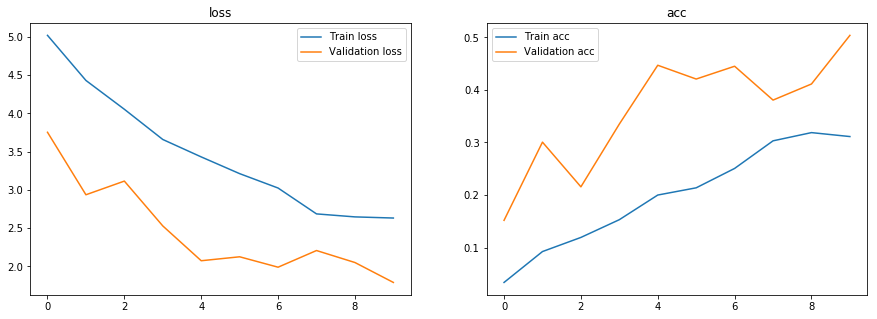

In [25]:
show_final_history(history)